In [1]:
import sys

assert sys.version_info >= (3, 7)

TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


Instaliraćemo biblioteku gym koja pruža podršku za simulaciju okruženja koja se koriste za proučavanje algoritama učenja potkrepljivanjem.

In [6]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gym
    %pip install -q -U gym[classic_control,box2d,atari,accept-rom-license]

# Uvod u OpenAI gym

In [7]:
import gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

CartPole (verzija 1) je vrlo jednostavno okruženje sastavljeno od kolica koja se mogu kretati levo ili desno, i šipke postavljene vertikalno na tim kolicima. Agent pomera kolica levo ili desno da bi održao šipku uspravnom.

gym.envs.registry sadrži sva dostupna okruženja:

In [ ]:
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

In [9]:
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)

Okruženje inicijalizujemo funkcijom `reset` . Promenljiva `obs` sadrži vrednosti koje agent može da posmatra u okruženju, a `info` dodatne informacije o samom okruženju.

In [10]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [11]:
info

{}

U slučaju okruženja CartPole, svako posmatranje je 1D NumPy niz sastavljen od 4: koja predstavljaju horizontalni položaj kolica, njihovu brzinu, ugao šipke (0 = vertikalno) i brzinu ugaonog pomeraja šipke.

Okruženje se može vizualizovati pozivanjem njegove metode render(). 

In [57]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

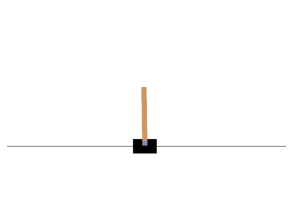

In [58]:

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Agent bira akciju iz skupa mogućih akcija. Prostor ima samo dve moguće akcije: ubrzavanje prema levo (0) ili prema desno (1).
Pošto se šipka naginje prema desno (obs[2] > 0), hajde da ubrzamo kola prema desno:

In [59]:
env.action_space

Discrete(2)

samo dve moguće akcije: ubrzavanje prema levo (0) ili prema desno (1).

Pošto se šipka naginje prema desno (obs[2] > 0), hajde da ubrzamo kola prema desno:

In [1]:
action = 1  
obs, reward, done, truncated, info = env.step(action)
obs

NameError: name 'env' is not defined

Primetimo da se kolica sada kreću prema desno (`obs[1] > 0`). Šipka je još uvek nagnuta prema desno (`obs[2] > 0`), ali njena ugaona brzina je sada negativna (`obs[3] < 0`), pa će verovatno biti nagnuta prema levo nakon sledećeg koraka.

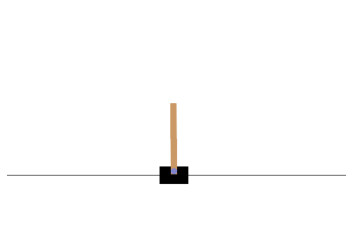

In [61]:
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

Okruženje nam govori i koliku nagradu je agent osvoio.

In [17]:
reward

1.0

Kada se igra završi, u okruženju će promenljiva `done` imati vrednost `done=True`. Trenutno, igra još nije gotova

In [18]:
done

False

Neke biblioteke koje se koriste za lakši rad sa okruženjom mogu da prekinu okruženje ranije. Na primer, kada se dostigne vremenski limit ili kada objekat izađe iz granica. U tom slučaju, `truncated` će biti postavljen na `True`. U ovom slučaju, okruženje još nije prekinuto:

In [19]:
truncated

False

Na kraju, `info` je `dictionary` okruženja koje sadrži neke dodatne informacije koje   mogu biti korisne za otklanjanje grešaka ili za obuku. Na primer, u nekim igrama može ukazivati na broj života koje agent ima.

In [20]:
info

{}

Sekvenca koraka od trenutka kada se okruženje resetuje do trenutka kada je završeno ili skraćeno naziva se "epizoda". Na kraju epizode (tj. kada `step()` vrati `done=True` ili `truncated=True`), trebalo bi da resetujemo okruženje pre nego što nastavimo da ga koristimo.

In [21]:
if done or truncated:
    obs, info = env.reset()

Da bi agent održao šipku u uspravnom položaju potrebno je da napravimo __politiku__ po kojoj će se agent ponašati u odnosu na stanje okruženja.

# Primer jednostavne politike

Ako se šipka naginje na levo, onda ćemo pomeriti kolica na levo.

In [22]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [23]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Kao što je bilo očekivano, ova strategija je nedovoljno dobra: najbolje što je agent uspeo da uradi ovom politikom je da drži šipku uspravno samo 63 koraka. Ovo okruženje se smatra rešenim kada agent drži šipku uspravno 200 koraka.

In [24]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

# Politika naučena neuronskom mrežom

Napravićemo neuronsku mrežu koja će uzimati posmatranja `obs` kao ulaze i računati verovatnoće akcija za svako posmatranje. Da bi se odabrala akcija, mreža će proceniti verovatnoću za svaku akciju, a zatim ćemo odabrati akciju nasumično prema procenjenim verovatnoćama. U slučaju okruženja CartPole, postoje samo dve moguće akcije (levo ili desno), tako da nam je potreban samo jedan izlazni neuron: on će izračunati verovatnoću `p` za akciju 0 (levo), a verovatnoća za akciju 1 (desno) biće `1 - p`.

In [25]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

U ovom konkretnom okruženju, prethodne akcije i posmatranja mogu se zanemariti, pošto svako posmatranje sadrži celokupno stanje okruženja. Ako bi postojalo neko skriveno stanje, možda bismo mogli da razmotrimo prethodne akcije i posmatranja kako bismo pokušali da zaključimo skriveno stanje okruženja. Na primer, ako bi okruženje otkrilo samo položaj kolica, ali ne i njihovu brzinu, morali bismo da razmotrimo ne samo trenutno posmatranje, već i prethodno posmatranje kako bismo procenili trenutnu brzinu. Drugi primer je ako posmatranja imaju šum: možda bismo želeli da koristimo poslednjih nekoliko posmatranja da procenimo najverovatnije trenutno stanje. U našem okruženju trenutno posmatranje je bez šuma i sadrži potpuno stanje okruženja.

Odabraćemo nasumičnu akciju na osnovu verovatnoće koju daje neuronska mreža, umesto da jednostavno odaberemo akciju sa najvećom verovatnoćom. Ovaj pristup omogućava agentu da pronađe pravu ravnotežu između _istraživanja_ novih akcija i _iskorišćavanja_ akcija za koje se zna da dobro funkcionišu. Evo analogije: pretpostavimo da idemo u restoran prvi put, i sva jela izgledaju podjednako privlačno, pa nasumično odaberemo jedno. Ako se ispostavi da je dobro, možemo povećati verovatnoću da ga naručimo sledeći put, ali ne treba tu verovatnoću povećati na 100%, inače nikada nećemo probati ostala jela, neka od kojih mogu biti čak i bolja od onog koje smo probali.

Napravićemo malu funkciju politike koja će koristiti neuronsku mrežu da bi dobila verovatnoću kretanja ulevo, a zatim ćemo je iskoristiti za jednu epizodu:

In [26]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

Da... prilično loše. 

Hajde da vidimo da li neuronska mreža može sama da nauči bolju politiku. 

# Policy Gradients


Da bismo trenirali ovu neuronsku mrežu, moraćemo da definisemo ciljne verovatnoće **y**. Ako je akcija dobra, treba da povećamo njenu verovatnoću, a suprotno, ako je loša, treba da je smanjimo. Ali kako znamo da li je akcija dobra ili loša? Problem je u tome što većina akcija ima odložene efekte, pa kada osvojimo ili izgubimo poene u epizodi, nije jasno koje su akcije doprinele tom rezultatu: da li je to bila samo poslednja akcija? Ili poslednjih 10? Ili samo jedna akcija 50 koraka ranije? Ovo se naziva _problemom dodeljivanja zasluga_.

Algoritam _Gradijentne Politike_ rešava ovaj problem tako što prvo igra više epizoda, a zatim postavi akcije blizu pozitivnih nagrada verovatnim, dok se akcije blizu negativnih nagrada čine manje verovatnim. Prvo se odigra igra, pa se onda vraćamo u nazad i `razmišljamo` o donetim odlukama i procenjujemo koja je bila dobra.

Hajde da počnemo tako što ćemo kreirati funkciju za igranje jednog koraka koristeći model. Takođe ćemo za sada pretpostaviti da je koja god akcija da preduzme prava, tako da možemo izračunati gubitak i njegove gradijente. Samo ćemo za sada sačuvati ove gradijente, i modifikovati ih kasnije u zavisnosti od toga koliko je akcija bila dobra ili loša.

In [27]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

Napravićemo još jednu funkciju koja će se oslanjati na funkciju `play_one_step()` da bi igrala više epizoda, vraćajući sve nagrade i gradijente, za svaku epizodu i svaki korak:

In [28]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

Algoritam Gradijenata Politike koristi model da bi igrao epizodu nekoliko puta (na primer, 10 puta), a zatim se vraća i gleda sve nagrade, oslabi ih i normalizuje. Napravićemo par pomoćnih funkcija: prva će izračunati oslabljene nagrade; druga će normalizovati oslabljene.

In [29]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Neka je bilo 3 akcije i nakon svake akcije neka je nagrada: prvo 10, zatim 0, zatim -50. Ako je faktor slabljenja 80%, tada će 3. akcija dobiti -50 (punu vrednost), ali će 2. akcija dobiti samo -40 (80% za poslednju nagradu), i 1. akcija će dobiti 80% od -40 (-32) plus punu vrednost za prvu nagradu (+10), što dovodi do oslabljene nagrade od -22:

In [30]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [31]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [32]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [33]:

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [34]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [35]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 187.8

In [36]:

np.random.seed(42)
show_one_episode(pg_policy)

In [62]:
model.save('cartpole-nn-policy-gradient.h5')